# Imports

In [1]:
import os, gc
import torch
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.max_columns', None)

# Initial setup

## GPU

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


## Pytorch lightning and forecasting

In [3]:
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, MultiNormalizer

# Load input

In [4]:
import sys
sys.path.append( '..' )
from script.utils import *
from dataclasses import dataclass

@dataclass
class args:
    result_folder = '../../TFT-pytorch-AgeGroups(Updated Results)/results/AGE1829' # '../scratch/age_subgroup/AGE1829/' 
    figPath = os.path.join(result_folder, 'figures_morris_updated')
    checkpoint_folder = os.path.join(result_folder, 'checkpoints')
    input_filePath = '../2022_May_age_groups/Top_100.csv'

    configPath = '../configurations/age_groups.json'
    model_path = get_best_model_path(checkpoint_folder)

    # set this to false when submitting batch script, otherwise it prints a lot of lines
    show_progress_bar = True

if not os.path.exists(args.figPath):
    os.makedirs(args.figPath, exist_ok=True)

Checkpoint model best-epoch=2.ckpt.


In [5]:
start = datetime.now()
print(f'Started at {start}')

total_data = pd.read_csv(args.input_filePath)
print(total_data.shape)
total_data.head()

Started at 2023-03-22 11:19:30.724226
(80900, 14)


,FIPS,UNDER5,AGE517,AGE1829,AGE3039,AGE4049,AGE5064,AGE6574,AGE75PLUS,Date,VaccinationFull,Cases,TimeFromStart,SinWeekly
0,2261,0.0062,0.016,0.014,0.0146,0.0117,0.0235,0.0103,0.0004,2020-12-13,0.0,2.0,288,-0.7818
1,2261,0.0062,0.016,0.014,0.0146,0.0117,0.0235,0.0103,0.0004,2020-12-14,0.0,1.0,289,0.0000
2,2261,0.0062,0.016,0.014,0.0146,0.0117,0.0235,0.0103,0.0004,2020-12-15,0.0,1.0,290,0.7818
3,2261,0.0062,0.016,0.014,0.0146,0.0117,0.0235,0.0103,0.0004,2020-12-16,0.0,2.0,291,0.9749
4,2261,0.0062,0.016,0.014,0.0146,0.0117,0.0235,0.0103,0.0004,2020-12-17,0.0,8.0,292,0.4339


# Model

In [6]:
tft = TemporalFusionTransformer.load_from_checkpoint(args.model_path)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 16.5k


# Config

In [7]:
import json
from Class.Parameters import Parameters

with open(args.configPath, 'r') as input_file:
  config = json.load(input_file)

parameters = Parameters(config, **config)

# this is only because the subgroups were trained using individual static features
parameters.data.static_features = tft.static_variables

In [8]:
targets = parameters.data.targets
time_idx = parameters.data.time_idx
tft_params = parameters.model_parameters

batch_size = tft_params.batch_size
max_prediction_length = tft_params.target_sequence_length
max_encoder_length = tft_params.input_sequence_length

# Processing

In [9]:
total_data['Date'] = pd.to_datetime(total_data['Date'].values) 
total_data['FIPS'] = total_data['FIPS'].astype(str)
print(f"There are {total_data['FIPS'].nunique()} unique counties in the dataset.")

There are 100 unique counties in the dataset.


## Adapt input to encoder length
Input data length needs to be a multiple of encoder length to created batch data loaders.

In [10]:
train_start = parameters.data.split.train_start
total_data = total_data[total_data['Date']>=train_start]
total_data[time_idx] = (total_data["Date"] - total_data["Date"].min()).apply(lambda x: x.days)

## Train validation test split and scaling

In [11]:
train_data, validation_data, test_data = train_validation_test_split(
    total_data, parameters
)

Train samples 63700, validation samples 2800, test samples 2800
637 days of training, 15 days of validation data, 15 days of test data.


In [12]:
# sensitivity analysis is only done on the train period
train_scaled, _, _, target_scaler = scale_data(
    train_data, validation_data, test_data, parameters
)

Scaling static and dynamic input features: ['AGE1829', 'VaccinationFull']
Scaling targets ['Cases']


## Create dataset and dataloaders

In [13]:
def prepare_data(data: pd.DataFrame, pm: Parameters, train=False):
  data_timeseries = TimeSeriesDataSet(
    data,
    time_idx= time_idx,
    target=targets,
    group_ids=pm.data.id, 
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_reals=pm.data.static_features,
    # static_categoricals=['FIPS'],
    time_varying_known_reals = pm.data.time_varying_known_features,
    time_varying_unknown_reals = pm.data.time_varying_unknown_features,
    target_normalizer = MultiNormalizer(
      [GroupNormalizer(groups=pm.data.id) for _ in range(len(targets))]
    )
  )

  if train:
    dataloader = data_timeseries.to_dataloader(train=True, batch_size=batch_size)
  else:
    dataloader = data_timeseries.to_dataloader(train=False, batch_size=batch_size*8)

  return dataloader

In [14]:
train_dataloader = prepare_data(train_scaled, parameters)
gc.collect()

19919

# Prediction Processor and PlotResults

In [15]:
from Class.PredictionProcessor import PredictionProcessor

processor = PredictionProcessor(
    time_idx, parameters.data.id[0], max_prediction_length, targets, 
    train_start, max_encoder_length
)

In [16]:
from Class.Plotter import *

plotter = PlotResults(args.figPath, targets, show=args.show_progress_bar)

# Train results

In [17]:
print(f'\n---Training results--\n')

# [number of targets, number of examples, prediction length (15)]
train_predictions, train_index = tft.predict(
    train_dataloader, return_index=True, show_progress_bar=args.show_progress_bar
)

train_predictions = upscale_prediction(
    targets, train_predictions, target_scaler, max_prediction_length
)

gc.collect()


---Training results--



Predict:   0%|          | 0/120 [00:00<?, ? batches/s]

19

# Morris method

## Scale

In [18]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

features = parameters.data.static_features + parameters.data.dynamic_features

minmax_scaler = MinMaxScaler()
train_minmax_scaled = minmax_scaler.fit_transform(train_data[features])

standard_scaler = StandardScaler().fit(train_data[features])

## Calculate

In [19]:
# delta_values = [1e-2, 1e-3, 5e-3, 9e-3, 5e-4, 1e-4, 5e-5, 1e-5]
delta_values = [1e-3, 1e-1]
results = {
    'Delta': [],
    'Feature': [],
    'Mu_star':[],
    'Prediction_change':[],
    'Morris_sensitivity':[],
    'Absolute_prediction_change':[],
    'Absolute_mu_star': [],
    'Absolute_morris_sensitivity':[],
}

In [20]:
for delta in delta_values:
    print(f'---Delta {delta}---\n')
    for index, feature in enumerate(features):
        print(f'Feature {feature}')
        # add delta at min max scale
        data = train_minmax_scaled.copy()
        data[index] += delta
        data = minmax_scaler.inverse_transform(data) # return to original scale

        # # replace the value in the standard normalized data
        data = standard_scaler.transform(data)
        train_scaled_copy = train_scaled.copy()
        train_scaled_copy[feature] = data[:, index]

        # infer on the changed data
        dataloader = prepare_data(train_scaled_copy, parameters)
        new_predictions = tft.predict(
            dataloader, show_progress_bar=args.show_progress_bar
        )
        # scale back to original
        new_predictions = upscale_prediction(
            targets, new_predictions, target_scaler, max_prediction_length
        )

        # sum up the change in prediction
        delta_prediction, abs_delta_prediction, N = 0, 0, 0
        for target_index in range(len(targets)):
            diff = new_predictions[target_index] - train_predictions[target_index]
            
            delta_prediction += np.sum(diff)
            abs_delta_prediction += np.sum(abs(diff))

            N += len(new_predictions[target_index]) * max_prediction_length
        
        mu_star = delta_prediction / (N*delta)
        # since delta is added to min max normalized value, std from same scaling is needed
        standard_deviation = train_minmax_scaled[:, index].std()
        morris = mu_star * standard_deviation

        print(f'Prediction change {delta_prediction:.5g}, mu_star {mu_star:.5g}, \
              sensitivity {morris:.5g}')

        results['Delta'].append(delta)
        results['Feature'].append(feature)
        results['Mu_star'].append(mu_star)

        results['Prediction_change'].append(delta_prediction)
        results['Morris_sensitivity'].append(morris)

        abs_mu_star = abs_delta_prediction / (N*delta)
        abs_morris = abs_mu_star * standard_deviation
        print(f'Absolute prediction change {abs_delta_prediction:.5g}, \
              mu {abs_mu_star:.5g}, sensitivity {abs_morris:.5g}')
        
        results['Absolute_prediction_change'].append(abs_delta_prediction)
        results['Absolute_mu_star'].append(abs_mu_star)
        results['Absolute_morris_sensitivity'].append(abs_morris)
        print()
    #     break
    # break
    print()

---Delta 0.001---

Feature AGE1829


Predict:   0%|          | 0/120 [00:00<?, ? batches/s]

Prediction change -0.1329, mu_star -0.00014525,               sensitivity -1.4632e-05
Absolute prediction change 26.868,               mu 0.029364, morris 0.0029579

Feature VaccinationFull


Predict:   0%|          | 0/120 [00:00<?, ? batches/s]

Prediction change 0.46971, mu_star 0.00051335,               sensitivity 0.00015771
Absolute prediction change 24.501,               mu 0.026778, morris 0.0082265


---Delta 0.1---

Feature AGE1829


Predict:   0%|          | 0/120 [00:00<?, ? batches/s]

Prediction change -12.558, mu_star -0.00013724,               sensitivity -1.3825e-05
Absolute prediction change 146.13,               mu 0.0015971, morris 0.00016088

Feature VaccinationFull


Predict:   0%|          | 0/120 [00:00<?, ? batches/s]

Prediction change 100.29, mu_star 0.0010961,               sensitivity 0.00033674
Absolute prediction change 135.86,               mu 0.0014849, morris 0.00045617




## Dump

In [21]:
result_df = pd.DataFrame(results)
result_df.to_csv(os.path.join(args.figPath, 'Morris.csv'), index=False)
result_df

,Delta,Feature,Mu_star,Prediction_change,Morris_sensitivity,Absolute_prediction_change,Absolute_mu_star,Absolute_morris_sensitivity
0,0.001,AGE1829,-0.000145,-0.132904,-0.000015,26.868103,0.029364,0.002958
1,0.001,VaccinationFull,0.000513,0.469711,0.000158,24.501450,0.026778,0.008227
2,0.100,AGE1829,-0.000137,-12.557846,-0.000014,146.130356,0.001597,0.000161
3,0.100,VaccinationFull,0.001096,100.291519,0.000337,135.863907,0.001485,0.000456


## Plot

In [22]:
from Class.PlotConfig import *
from matplotlib.ticker import ScalarFormatter

formatter = ScalarFormatter(useOffset=True)
formatter.set_powerlimits((-3, 3))


0.001


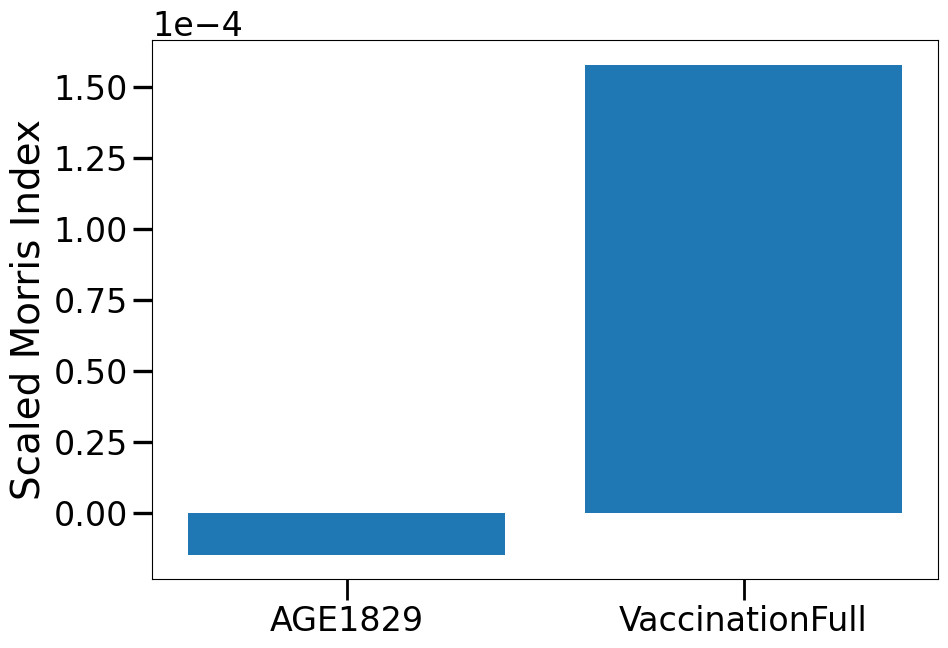

0.1


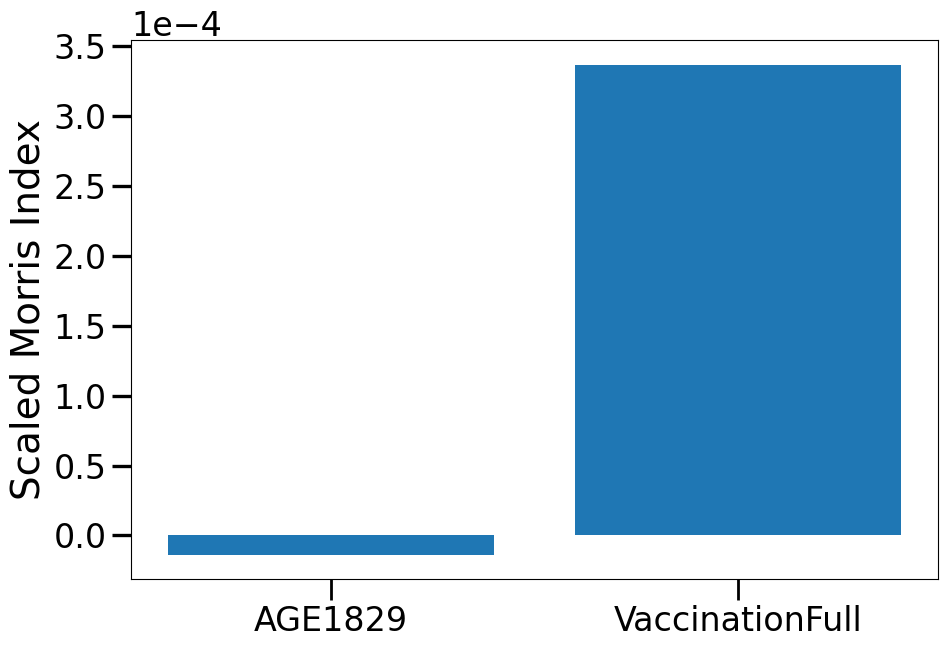

In [28]:
for delta in delta_values:
    print(delta)
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.bar(features, result_df[result_df['Delta']==delta]['Morris_sensitivity'])
    
    ax.yaxis.set_major_formatter(formatter)
    ax.set_ylabel("Scaled Morris Index")
    fig.tight_layout()
    fig.savefig(os.path.join(args.figPath, f'delta_{delta}.jpg'), dpi=200)
    plt.show()
    # break

# End

In [ ]:
print(f'Ended at {datetime.now()}. Elapsed time {datetime.now() - start}')